<a href="https://colab.research.google.com/github/ddlxdd/SOCI40133/blob/main/Xiaochen_Ding_7_Prediction_and_Causal_Inference_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 7 - Prediction & Causal Inference

Last week, we explored (supervised) text classification, where we train a model to learn associations between text and some classification or value connected with it (e.g., what distinguishes a winning argument before the Supreme Court; can we extend our judgment regarding what documents are relevant to my thesis project to all of Google News; etc.) Classification often uses a representative sample of text about which we want to make inferences and then we use machine learning to learn "true" assignments and classify the rest.

This week, we explore two different types of inferences to out-of-sample populations. _Prediction_ involves our reasoned expectation regarding an unobserved state of the world, given the world in which we live and on which we have trained our prediction algorithm. Often this prediction is about the future world. We don't expect the U.S. Congress to talk about the identical things today and tomorrow, but today should contain some useful information. by contrast _causal inference_ poses the related by distinct challenge of our reasoned expectations regarding an unobserved state of the world IF we intervene in some way. In other words, what does the intervention cause, and how can we predict it to change the world. Causality has a deeply contested history in social science and philosophy, but it usually involves an "if," a difference between two counterfactual worlds, one where an event occurs and one where it doesn't.

Causal questions in text analysis may place the text in one or more of many positions we explore below: as cause, effect, confounder, mediator (or moderator), or collider. For example, assuming that everything spoken can be transcribed into text, saying something mean might hurt someone's feelings (text as cause). Doing something mean might cause someone to say something angry (text as effect). Apologizing might change the influence of doing something mean (text as mediator/moderator). A compliment might obscure the effect of doing something mean (text as confounder). And yelling something audaciously mean might yield a loud, emotional response, which both influence the likelihood that the interaction was recorded and subjected to analysis (text as collider). As you can see, in a single conversation, text can play all of these roles. Why do we care about cause and effect with text? Because while words appear to exert power in the world, which words spoken under what circumstances by whom? Causal analysis attempts to get at the question, if _X_ was written or spoken, _Y_ would happen.

In [1]:
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-j439ptax
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-j439ptax
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
import os #For managing the operating system
import requests #For getting files
import zipfile #For managing zips
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas as pd #Gives us DataFrames
import numpy as np #Math and matrices
import matplotlib.pyplot as plt #For graphics

# statsmodels is a popular Python statistics package
import statsmodels.api as sm
# Let's also import its graphics module
import statsmodels.graphics.api as smg
# And the mediation module
from statsmodels.stats.mediation import Mediation

# Pipelines to add text-based quantiative variables for regressions
from transformers import pipeline

# We have a lot of features, so let's set Pandas to show all of them.
pd.set_option('display.max_columns', None)

# Prediction
We can make predictions about a range of different text 'populations'. We can use texts in English to predict their translations in French. We can use newspaper articles from 2012 to 2022 to forecast the contents of 2023 newspaper articles (e.g., a [time series](https://en.wikipedia.org/wiki/Time_series)). Or we can "nowcast" by using real-time social information such as Tweets to predict when an important event is happening, such as a riot.

If we don't have any information about how the new population will vary from the population we modeled, then prediction is implemented in the same way as in-sample inference. E.g., if you have a categorization of 2022 emails as spam or ham, you could predict whether 2023 emails are spam the same way you predicted 2022 emails. On the other hand, if you have new information, such as a trend beginning in December 2022 for spam emails to have "Urgent:" in the subject line, your 2023 prediction may differ by putting more weight on that indicator relative to others.

In this way, prediction is similar to the classifications we performed last last week, incorporating multidimensional trends (e.g., time, place, source) learnable from your current corpus. We encourage you to think more about this if you are interested in predicting the future of your corpus!

## <font color="red">*Exercise 1*</font>

<font color="red">Describe 2 separate predictions relevant to your project and associated texts, which involve predicting text that has not been observed based on patterns that have. Then, in a single, short paragraph, describe a research design through which you could use textual features and the tools of classification and regression to evaluate these predictions.

**Prediction of Mood States**: Predicting the mood state (positive, negative, neutral) of a forum post based on the language and sentiment expressed in the text. I will classify the mood expressed in each post.

**Prediction of Mood Shifts Over Time**: Predicting shifts in mood over time for individuals based on the sequence of their posts. This involves analyzing the temporal progression of moods to identify patterns, such as rapid cycling or seasonal effects on mood states.


**Research Design**


**Data Preprocessing**: Clean and preprocess the text data. organize posts by user and date to analyze temporal patterns.

**Feature Extraction**: Extract textual features relevant to mood expression, such as sentiment scores, frequency of mood-related words.

**Model Development**:

For mood state prediction, train a classification model (e.g., logistic regression, support vector machines, or a neural network) using the extracted features as inputs to predict the mood category of each post.

**Evaluation**: Assess the models' performance using appropriate metrics. For the classification model, metrics could include accuracy, precision, recall, and F1 score.


# Text in causal inference

In causal inference, we are interested in the effect of a _treatment_ on an _outcome_. There are five types of variables that could be directly involved in our causal model, and any could be a text variable. This figure from [Keith et al. 2020](https://aclanthology.org/2020.acl-main.474.pdf) concisely shows the five positions for variables in acyclic (i.e., no arrows flow back into themselves) causal inference: treatment, mediator, outcome, confounder, and collider.

<img src="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" alt="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" style="width:500px">

"Text as treatment" means the effect of text on other variables. For example, how does the news coverage of a politician affect their election chance? How does the sentiment of a Reddit post affect its upvotes?

Whether we're interested in text as treatment, mediator, outcome, or confounder, we have at our disposal the same causal inference strategies used with other forms of data, such as matching, difference in difference, regression discontinuity, and instrumental variables. Each of these methods usually gives you a more precise conditional identification of the causal influence than regressing an effect on a singular (purported) cause. For example, one of the readings for this week, [Saha 2019](https://doi.org/10.1145/3292522.3326032), uses propensity score matching, which is a straightforward method that works on most datasets (see Professor Gary King on [coarsened exact matching](https://www.youtube.com/watch?v=tvMyjDi4dyg)). For this assignment, we do not detail each of these causal strategies, but note several courses at UChicago that introduce these methods, as well as online textbooks (e.g., Scott Cunningham's [Causal Inference: The Mixtape](https://mixtape.scunning.com/)).

You can do causal inference on any sort of text data as long as you have a plausible _identification_ strategy, meaning an argument that you can correctly identify a causal effect if one exists using your data and analysis. For example, if you have a data from a randomized controlled trial (RCT) where you intervene randomly with some treatment, you can identify a causal effect with relative ease. Text exhibits a wide array of dependencies making unconditional randomization impossible, but we will attempt strategies that approach it.

# Text as treatment and outcome

To illustrate text as treatment and outcome, we will analyze a dataset of internet arguments. We have 8,895 pairs of comments, where one person makes a statement and the other responds. Our research question is thus: _How does the text of the first commenter affect the text of the respondent?_

The data comes from the [Internet Argument Corpus](https://nlds.soe.ucsc.edu/iac). Let's load the data and take a look.

In [ ]:
url = 'http://nldslab.soe.ucsc.edu/iac/iac_v1.1.zip'

req = requests.get(url)

filename = url.split('/')[-1]
with open(filename,'wb') as output_file:
    output_file.write(req.content)
print('Downloaded file: ' + url)

Downloaded file: http://nldslab.soe.ucsc.edu/iac/iac_v1.1.zip


In [ ]:
with zipfile.ZipFile('iac_v1.1.zip') as z:
   with z.open('iac_v1.1/data/fourforums/annotations/mechanical_turk/qr_averages.csv') as f:
      qr = pd.read_csv(f)

   with z.open('iac_v1.1/data/fourforums/annotations/mechanical_turk/qr_meta.csv') as f:
      md = pd.read_csv(f)

# columns = ['key', 'nicenasty', 'questioning-asserting', 'negotiate-attack', 'fact-feeling']
# qr_sub = qr[columns]
# qr_sub = qr

pairs = qr.merge(md, how='inner', on='key')
pairs = pairs[~pairs.quote_post_id.isnull() & ~pairs.response_post_id.isnull()]
pairs

,key,discussion_id_x,agree-disagree,agreement,agreement_unsure,attack,attack_unsure,defeater-undercutter,defeater-undercutter_unsure,fact-feeling,fact-feeling_unsure,negotiate-attack,negotiate-attack_unsure,nicenasty,nicenasty_unsure,personal-audience,personal-audience_unsure,questioning-asserting,questioning-asserting_unsure,sarcasm,sarcasm_unsure,discussion_id_y,response_post_id,quote_post_id,term,task1 num annot,task2 num annot,task2 num disagree,quote,response
0,"(731, 1)",6032,0.333333,-1.333333,0.333333,0.333333,0.000000,0.500000,0.000000,0.333333,0.333333,3.000000,0.250000,0.666667,0.166667,-2.250000,0.250000,-4.250000,0.000000,0.200000,0.166667,6032,149609,149552.0,None,6,6,4,I remember looking at the classic evolutionary...,Why do you find it necessary to fit observatio...
1,"(660, 3)",10217,0.600000,0.285714,0.000000,0.714286,0.000000,-2.500000,0.000000,1.000000,0.000000,-2.000000,0.000000,1.142857,0.000000,-1.500000,0.000000,0.500000,0.000000,0.142857,0.000000,10217,277697,277459.0,yes,7,5,2,So they (pro-life peeps) say abortion is murde...,"Yes, you are missing something. How come age d..."
2,"(114, 5)",3462,0.600000,-1.500000,0.000000,1.333333,0.000000,1.000000,0.000000,1.500000,0.000000,-1.500000,0.000000,2.166667,0.000000,-4.000000,0.000000,-1.500000,0.000000,0.000000,0.000000,3462,76012,75976.0,No terms in first 10,6,5,2,'If the solar system was brought about by an a...,"C.S.Lewis believes things on faith, yet we are..."
3,"(43, 3)",9930,0.166667,-0.833333,0.333333,1.500000,0.000000,0.400000,0.000000,1.500000,0.166667,-2.000000,0.000000,1.666667,0.000000,-2.800000,0.000000,0.000000,0.000000,0.000000,0.000000,9930,264824,264697.0,well,6,6,5,...to ToE because it means genetic evolution i...,"Well, it might help if you could propose a mec..."
4,"(1314, 0)",5352,0.142857,-1.666667,0.166667,0.000000,0.166667,-1.166667,0.166667,-0.833333,0.333333,0.833333,0.333333,0.166667,0.166667,-3.333333,0.166667,-0.166667,0.166667,0.600000,0.166667,5352,128326,128325.0,you,6,7,6,Sir Issac Newton was an idiot and you are a ge...,"You really think so? Im flattered, but I think..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,"(580, 4)",821,0.800000,-2.000000,0.166667,-0.500000,0.166667,1.000000,0.000000,1.333333,0.166667,-1.000000,0.000000,0.500000,0.166667,0.000000,0.000000,0.000000,0.000000,0.200000,0.166667,821,67788,67785.0,oh,6,5,1,Why do some of you guys insist on being rabid ...,oh because for the past decade or so they have...
9997,"(694, 4)",9258,0.000000,-3.200000,0.200000,0.200000,0.200000,-1.800000,0.000000,1.600000,0.400000,-1.200000,0.200000,0.600000,0.200000,-1.600000,0.000000,1.800000,0.000000,0.000000,0.200000,9258,241951,241848.0,but,5,5,5,But I see two people involved here. Whether th...,But the embryo is a mere clump of flesh inside...
9998,"(916, 6)",10301,0.000000,-3.000000,0.000000,-2.400000,0.000000,-2.400000,0.000000,-2.400000,0.000000,2.800000,0.000000,-2.400000,0.000000,-4.200000,0.000000,1.800000,0.000000,0.000000,0.200000,10301,281530,281509.0,None,5,5,5,I disagree with you because the logic you have...,**\n Sez u. Your problem being that when you a...
9999,"(1348, 1)",6032,0.857143,0.800000,0.600000,0.600000,0.200000,3.000000,0.000000,-0.600000,0.400000,-3.000000,0.000000,0.600000,0.200000,3.000000,0.000000,3.000000,0.000000,0.000000,0.200000,6032,149609,149552.0,No terms in first 10,5,7,1,What I don't understand is why YEC's want to L...,That's what faith does. It limits your options.


Note that each comment and response were annotated by workers on Amazon Mechanical Turk, which we piloted last week. Variables like "agree-disagree" are the averages of annotations made by workers on Mechanical Turk on an 11-point Likert scale (-5 to 5) using a slider. Workers were asked questions, and then had the opportunity to note whether or not their were "unsure" about their assessment (Boolean - Y/N):

* __agree/disagree__ (Boolean -- Y/N): Does the respondent agree (0) OR disagree (1) with the prior post?
* __sarcasm__ (Boolean -- Y/N): Is the respondent using sarcasm (1 - Y; 0 - N)?
* __fact/feeling__  (-5 to 5): Is the respondent attempting to make a fact based argument (-5) OR appealing to feelings and emotions (+5)?
* __attack/insult__ (-5 to 5): Is the respondent being supportive/respectful (-5) OR are they attacking/insulting in their writing (+5)?
* __nice/nasty__ (-5 to 5): Is the respondent attempting to be nice (-5) OR is their attitude fairly nasty (+5)?
* __audience__ (-5 to 5): Is the respondent's arguments intended more to be interacting directly with the original poster (-5) OR with a wider audience (+5)?
* __undercutting__ (-5 to 5): Is the argument of the respondent targeted at the entirety of the original poster's argument (-5) OR is the argument of the respondent targed at a more specific idea within the post (+5)?
* __negotiate/attack__ (-5 to 5): Does the respondent seem to have an argument of their own (-5) OR is the respondent simply attacking the original poster's argument (+5)?
* __question/assert__ (-5 to 5): Is the respondent questioning the original poster (-5) OR is the respondent asserting their own ideas (+5)?

Unfortunately the dataset only has the "response" annotated, not the original "quote." However, some "responses" in this dataset are also "quotes," meaning we can form triples of quote-response-response. Let's self-merge this dataframe to get these "r1" and "r2" pairs where both texts have annotations.

In [ ]:
# Self-merge where the 'response' matches another 'quote' in the DataFrame
triples = pairs.merge(pairs,left_on='response',right_on='quote',how='inner',suffixes=('_r1','_r2'))

# Rename and reorder columns
triples = triples.rename(columns={'quote_r1':'quote', 'quote_r2':'response1', 'response_r2':'response2'})
triples = triples.drop(columns=['response_r1'])
front_columns = [
                 'quote','response1','response2','attack_r1','fact-feeling_r1','nicenasty_r1','sarcasm_r1',
                 'agreement_r2'
                ]
triples = triples.dropna(subset=front_columns)
triples = triples[front_columns].join(triples.drop(columns=front_columns))

# Display triples
triples

,quote,response1,response2,attack_r1,fact-feeling_r1,nicenasty_r1,sarcasm_r1,agreement_r2,key_r1,discussion_id_x_r1,agree-disagree_r1,agreement_r1,agreement_unsure_r1,attack_unsure_r1,defeater-undercutter_r1,defeater-undercutter_unsure_r1,fact-feeling_unsure_r1,negotiate-attack_r1,negotiate-attack_unsure_r1,nicenasty_unsure_r1,personal-audience_r1,personal-audience_unsure_r1,questioning-asserting_r1,questioning-asserting_unsure_r1,sarcasm_unsure_r1,discussion_id_y_r1,response_post_id_r1,quote_post_id_r1,term_r1,task1 num annot_r1,task2 num annot_r1,task2 num disagree_r1,key_r2,discussion_id_x_r2,agree-disagree_r2,agreement_unsure_r2,attack_r2,attack_unsure_r2,defeater-undercutter_r2,defeater-undercutter_unsure_r2,fact-feeling_r2,fact-feeling_unsure_r2,negotiate-attack_r2,negotiate-attack_unsure_r2,nicenasty_r2,nicenasty_unsure_r2,personal-audience_r2,personal-audience_unsure_r2,questioning-asserting_r2,questioning-asserting_unsure_r2,sarcasm_r2,sarcasm_unsure_r2,discussion_id_y_r2,response_post_id_r2,quote_post_id_r2,term_r2,task1 num annot_r2,task2 num annot_r2,task2 num disagree_r2
0,I remember looking at the classic evolutionary...,Why do you find it necessary to fit observatio...,"Evolution has no goals, it is merely a beautif...",0.333333,0.333333,0.666667,0.200000,-2.833333,"(731, 1)",6032,0.333333,-1.333333,0.333333,0.000000,0.500000,0.0,0.333333,3.000000,0.25,0.166667,-2.250000,0.25,-4.250000,0.0,0.166667,6032,149609,149552.0,None,6,6,4,"(610, 2)",6032,0.600000,0.166667,0.333333,0.166667,-3.50,0.0,1.333333,0.166667,3.500000,0.0,0.500000,0.333333,-4.000000,0.0,1.500000,0.0,0.0,0.166667,6032,149673,149609.0,None,6,5,2
1,What is the fun in that?,"Seriously? Well, I come here hoping for someth...","nah, I was just poking fun because I can! Pers...",-0.600000,-2.200000,0.000000,0.000000,-2.166667,"(697, 2)",5205,0.833333,-2.400000,0.000000,0.000000,-5.000000,0.0,0.000000,2.000000,0.00,0.000000,0.000000,0.00,-2.000000,0.0,0.000000,5205,122800,122780.0,None,5,6,1,"(1267, 0)",5205,0.600000,0.333333,0.833333,0.166667,-1.50,0.0,-1.333333,0.500000,2.000000,0.0,0.500000,0.166667,-3.000000,0.0,-1.500000,0.0,0.2,0.166667,5205,123129,122800.0,None,6,5,2
2,"First off, the scientific method goes:\n \n 1)...",You guys know me. Always happy to correct anyo...,"Ah, thanks for the correction, although there ...",2.400000,2.800000,2.200000,0.000000,-0.400000,"(9, 0)",9449,0.400000,0.600000,0.200000,0.200000,-2.666667,0.0,0.200000,-3.666667,0.00,0.200000,0.333333,0.00,3.666667,0.0,0.200000,9449,247240,247225.0,you,5,5,3,"(1393, 1)",9449,1.000000,0.200000,0.800000,0.200000,NaN,NaN,1.200000,0.200000,NaN,NaN,1.000000,0.400000,NaN,NaN,NaN,NaN,0.0,0.400000,9449,247243,247240.0,No terms in first 10,5,7,0
3,You can ignore the obvious question. This is w...,Actually what they are really doing is ignorin...,"Really, then show me how I'm wrong - without d...",-3.500000,-3.166667,-3.166667,0.166667,-1.833333,"(1077, 1)",3467,0.400000,-4.333333,0.000000,0.000000,-4.666667,0.0,0.000000,-0.666667,0.00,0.000000,-2.000000,0.00,3.000000,0.0,0.000000,3467,73741,73738.0,actually,6,5,3,"(622, 1)",3467,0.600000,0.166667,-1.333333,0.166667,2.50,0.0,0.333333,0.166667,1.500000,0.0,0.000000,0.166667,0.000000,0.0,-1.500000,0.0,0.2,0.166667,3467,73783,73741.0,really,6,5,2
4,Its really sad what these gay predator priests...,Homosexuals are attracted to adults of the sam...,Homosexuals are attracted to people of the sam...,0.166667,2.166667,-0.166667,0.400000,-2.666667,"(611, 0)",4337,0.333333,-2.000000,0.166667,0.166667,-0.750000,0.0,0.166667,-2.000000,0.00,0.166667,0.000000,0.00,3.750000,0.0,0.166667,4337,112008,111931.0,No terms in first 10,6,6,4,"(1350, 0)",4337,0.428571,0.000000,1.166667,0.000000,-2.50,0.0,0.666667,0.000000,-1.750000,0.0,1.166667,0.000000,-1.250000,0.0,3.250000,0.0,0.0,0.000000,4337,112012,112008.0,No terms in first 10,6,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Now we have 1,346 triples of quote-response1-response2, several text variables of response1 (e.g., "Is the respondent using sarcasm?") that may predict the agreement of response2. In other words: _Does a sarcastic comment lead to more agreement?_ Of course, as with almost all observational data, there are a number of confounders that make our identification difficult, but for now, let's explore how to run a simple regression in Python of agreement_r2 (dependent variable, commonly known as Y) on sarcasm_r1. Fortunately, we do have a strong case for identifying the direction of causality: Because response1 comes before response2, we can rule out the possibility that response2 affects response1.

In [ ]:
# We build an Ordinary Least Squares (OLS) model of agreement_r2 on sarcasm_r1.
# The function sm.add_constant() adds an intercept term to the regression (e.g., b in y = ax + b)
y = triples['agreement_r2']
X_cols = ['sarcasm_r1']
X = sm.add_constant(triples[X_cols])

lm1 = sm.OLS(y,X).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           agreement_r2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03364
Date:                Fri, 02 Feb 2024   Prob (F-statistic):              0.855
Time:                        23:57:58   Log-Likelihood:                -2581.1
No. Observations:                1340   AIC:                             5166.
Df Residuals:                    1338   BIC:                             5177.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2805      0.058    -22.263      0.000      -1.393      -1.168
sarcasm_r1    -0.0383      0.209     -0.183      0.855      -0.448       0.371
==============================================================================
Omnibus:                       86.710   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.903
Skew:                           0.642   Prob(JB):                     4.52e-23
Kurtosis:                       3.443   Cond. No.                         4.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for sarcasm_r1 is 0.855, which means that we fail to reject the null hypothesis that there is no effect of sarcasm on agreement. However, we have other variables that may be confounding the effect of pure "attack" or pure "sarcasm." Let's try adding 3 other annotations to the regression model.

In [ ]:
y = triples['agreement_r2']
X_cols = ['attack_r1','fact-feeling_r1','nicenasty_r1','sarcasm_r1']
X = sm.add_constant(triples[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           agreement_r2   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     12.60
Date:                Fri, 02 Feb 2024   Prob (F-statistic):           4.54e-10
Time:                        23:57:58   Log-Likelihood:                -2556.3
No. Observations:                1340   AIC:                             5123.
Df Residuals:                    1335   BIC:                             5149.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5276      0.075    -20.497      0.000      -1.674      -1.381
attack_r1           0.1808      0.073      2.475      0.013       0.038       0.324
fact-feeling_r1    -0.0248      0.033     -0.742      0.458      -0.090       0.041
nicenasty_r1        0.0748      0.079      0.951      0.342      -0.079       0.229
sarcasm_r1          0.6972      0.240      2.905      0.004       0.226       1.168
==============================================================================
Omnibus:                       86.269   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.200
Skew:                           0.629   Prob(JB):                     3.89e-23
Kurtosis:                       3.517   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The condition number (bottom-right of the output above) is 12.8, indicating high correlations between our predictors or collinearity. This is one of many issues to look out for when running regressions. Let's take a look at the correlations:

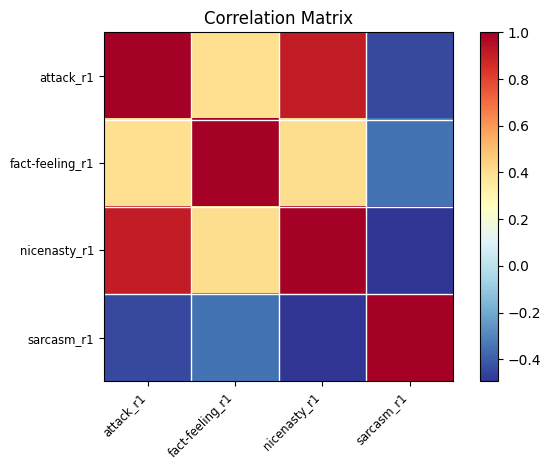

In [ ]:
corr_matrix = np.corrcoef(triples[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()

That's very high correlation between attack_r1 and nicenasty_r1 (recall that nasty is +5...this should be no surprise)! We found a significant effect of attack_r1, but not of nicenasty_r1. If we remove attack_r1 from the model, do you think nicenasty_r1 will be significant?

In [ ]:
y = triples['agreement_r2']
X_cols = ['fact-feeling_r1','nicenasty_r1','sarcasm_r1']
X = sm.add_constant(triples[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           agreement_r2   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     14.71
Date:                Fri, 02 Feb 2024   Prob (F-statistic):           2.00e-09
Time:                        23:58:00   Log-Likelihood:                -2559.3
No. Observations:                1340   AIC:                             5127.
Df Residuals:                    1336   BIC:                             5147.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5744      0.072    -21.798      0.000      -1.716      -1.433
fact-feeling_r1    -0.0183      0.033     -0.548      0.584      -0.084       0.047
nicenasty_r1        0.2454      0.038      6.488      0.000       0.171       0.320
sarcasm_r1          0.7113      0.240      2.959      0.003       0.240       1.183
==============================================================================
Omnibus:                       85.105   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.648
Skew:                           0.623   Prob(JB):                     8.46e-23
Kurtosis:                       3.518   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Yes, it is! And the t-value is even larger (i.e., stronger evidence of an effect). With this new regression model, we see a significant effect from attack_r1/nicenasty_r1 and sarcasm_r1, indicating both of these dimensions affect whether the response2 agrees with response1. Note that the coefficients are both positive: For attack_r1/nicenasty_r1, this means that a more "nasty" comment led to more disagreement, and for sarcasm_r1, this means that a more sarcasistic comment led to more disagreement.

For good measure, we can add other variables ourselves, such as sentiment and the character length of the comment. The length may be particularly important based on how it affects the annotations of Mechanical Turk workers. For example, as we were skimming through the data, it seemed like shorter comments were being rated as more nasty. For sentiment, let's use the convenient BERT pipeline we used last week and which we will detail and theorize in weeks to come.

In [ ]:
triples['length_r1'] = triples['response1'].apply(lambda x: len(x))
triples['length_r2'] = triples['response2'].apply(lambda x: len(x))

In [ ]:
sentiment = pipeline("sentiment-analysis")
result = sentiment("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

label: NEGATIVE, with score: 0.9991


This version of BERT is built only for texts of up to 512 tokens, so for comments longer than that, we truncate.

In [ ]:
%%time

triples['sentiment_r1'] = triples['response1'].apply(lambda x: sentiment(x[:512])[0]['score'])
triples['sentiment_r2'] = triples['response2'].apply(lambda x: sentiment(x[:512])[0]['score'])

CPU times: user 5min 16s, sys: 555 ms, total: 5min 16s
Wall time: 5min 29s


In [ ]:
y = triples['agreement_r2']
X_cols = ['fact-feeling_r1','nicenasty_r1','sarcasm_r1','length_r1','sentiment_r1']
X = sm.add_constant(triples[X_cols])

lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           agreement_r2   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     9.032
Date:                Sat, 03 Feb 2024   Prob (F-statistic):           1.87e-08
Time:                        00:03:37   Log-Likelihood:                -2558.8
No. Observations:                1340   AIC:                             5130.
Df Residuals:                    1334   BIC:                             5161.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.3211      0.522     -2.531      0.011      -2.345      -0.297
fact-feeling_r1    -0.0126      0.034     -0.370      0.711      -0.079       0.054
nicenasty_r1        0.2433      0.038      6.419      0.000       0.169       0.318
sarcasm_r1          0.6985      0.241      2.901      0.004       0.226       1.171
length_r1          -0.0001      0.000     -0.935      0.350      -0.000       0.000
sentiment_r1       -0.2225      0.534     -0.417      0.677      -1.270       0.825
==============================================================================
Omnibus:                       85.913   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.861
Skew:                           0.626   Prob(JB):                     4.61e-23
Kurtosis:                       3.526   Cond. No.                     7.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

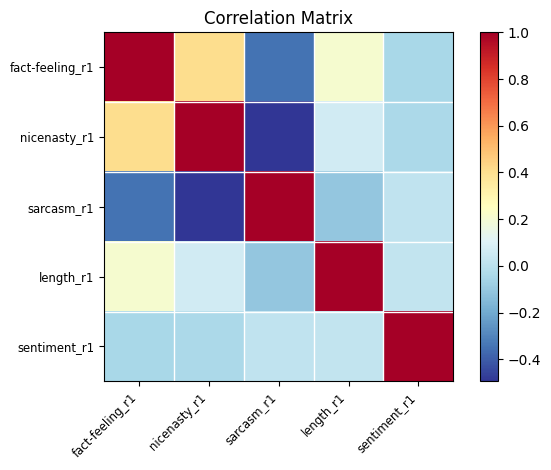

In [ ]:
corr_matrix = np.corrcoef(triples[X_cols].T)
smg.plot_corr(corr_matrix, xnames=X_cols)
plt.show()

The condition number is reasonably high, but our correlatons do not seem too strong. Overall, our finding of significant effects for attack_r1/nasty_r1 and sarcasm_r1 persists with these new controls! This sort of robustness or sensitivity analysis is important for making sure your finding is compelling to yourself and to your audience. Consider doing other robustness checks, such as standardizing these variables before running the regression or adding [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors). (To be clear, the analysis above would likely not be sufficient as proof of a causal effect for a peer-reviewed journal; you would likely need a more conditional approach using matching, instruments or differences in differences.)

## <font color="red">*Exercise 2*</font>

<font color="red">Propose a simple causal model in your data, or a different causal model in the annotated Internet Arguments Corpus (e.g., a different treatment, a different outcome), and test it using a linear or logistic regression model. If you are using social media data for your final project, we encourage you to classify or annotate a sample of that data (either compuationally or with human annotators) and examine the effect of texts on replies to that text (e.g., Reddit posts on Reddit comments, Tweets on Twitter replies, YouTube video transcripts on YouTube comments or ratings). You do not need to make a graph of the causal model, but please make it clear (e.g., "X affects Y, and C affects both X and Y.").
    
<font color="red">Also consider using the [ConvoKit datasets](https://convokit.cornell.edu/documentation/datasets.html)! Anytime there is conversation, there is an opportunity to explore the effects of early parts of the conversation on later parts. We will explore this further in Week 8 on Text Generation and Conversation.
    
<font color="red">***Stretch*** (not required): Propose a more robust identification strategy using either matching, difference in difference, regression discontinuity, or an instrumental variable. Each of these methods usually gives you a more precise identification of the causal effect than a unconditional regression. Scott Cunningham's [Causal Inference: The Mixtape](https://mixtape.scunning.com/) is a free textbook on these topics, and all have good YouTube video explanations.

In [4]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd


data = pd.read_csv("psychforums.csv")

# Path to model
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Function for sentiment analysis
def sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)[0].tolist()
    sentiment_list = ['negative', 'neutral', 'positive']
    best_sentiment_index = probabilities.index(max(probabilities))
    return {'negative': probabilities[0], 'neutral': probabilities[1], 'positive': probabilities[2], 'best_sentiment': sentiment_list[best_sentiment_index], 'best_sentiment_p':max(probabilities)}

# Analyzing sentiments and storing results
for index, row in data.iterrows():
    text = str(row["text"])
    sentiment_scores = sentiment_analysis(text)
    data.at[index, "Negative"] = sentiment_scores['negative']
    data.at[index, "Neutral"] = sentiment_scores['neutral']
    data.at[index, "Positive"] = sentiment_scores['positive']
    data.at[index, "Sentiment(roBERTa)"] = sentiment_scores['best_sentiment']
    data.at[index, "Sentiment probability(roBERTa)"] = sentiment_scores['best_sentiment_p']


data.to_csv('sentiment_psychforums_roBERTa.csv', index=False)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [9]:
import pandas as pd


data['date'] = data['date'].str.replace('» ', '', regex=False).str.strip()

# Convert 'date' column to datetime format
# The format is now '%a %b %d, %Y %I:%M %p' after removing the leading special character
data['date'] = pd.to_datetime(data['date'], format='%a %b %d, %Y %I:%M %p', errors='coerce')

# Now that 'date' is correctly formatted, extract the hour of day
data['hour_of_day'] = data['date'].dt.hour

In [10]:
data

,Unnamed: 0,date,text,Negative,Neutral,Positive,Sentiment(roBERTa),Sentiment probability(roBERTa),hour_of_day
0,0,2011-07-02 15:54:00,"Thought I'd make a general ""check up"" topic fo...",0.044856,0.311112,0.644033,positive,0.644033,15
1,1,2011-07-02 19:49:00,Partrly sunny with scattered anxiety.It was a ...,0.174064,0.521538,0.304398,neutral,0.521538,19
2,2,2011-07-02 19:59:00,"Interesting question, at the start of the week...",0.496626,0.439370,0.064004,negative,0.496626,19
3,3,2011-07-02 22:50:00,Good to know that you guys aren't doing all th...,0.295287,0.303750,0.400963,positive,0.400963,22
4,4,2011-07-02 23:16:00,I woke up not feeling too good at all. I woke ...,0.871361,0.116671,0.011969,negative,0.871361,23
...,...,...,...,...,...,...,...,...,...
4995,4995,2015-02-20 12:05:00,hey crackedi cant believe someone would doubt ...,0.343601,0.410993,0.245406,neutral,0.410993,12
4996,4996,2015-02-20 12:44:00,I had like 10 pdocs in 3 years (my old hospita...,0.181016,0.372373,0.446612,positive,0.446612,12
4997,4997,2015-02-20 12:58:00,jody wrote:hey crackedi cant believe someone w...,0.177243,0.354128,0.468629,positive,0.468629,12
4998,4998,2015-02-20 14:41:00,"Think I'm rapid cycling, or in the beginning o...",0.115494,0.451117,0.433389,neutral,0.451117,14


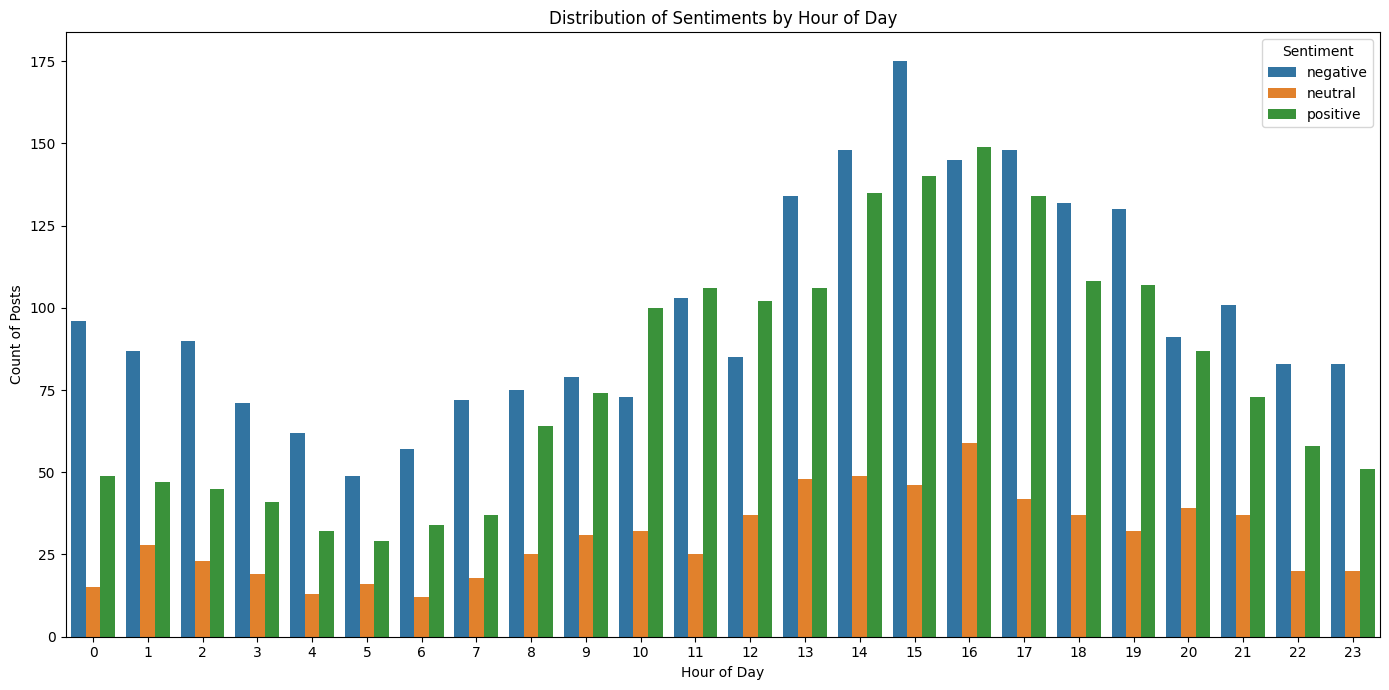

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Convert 'date' column to datetime format and extract the hour of day
data['date'] = pd.to_datetime(data['date'])
data['hour_of_day'] = data['date'].dt.hour

# Visualize the distribution of sentiments across different times of the day
plt.figure(figsize=(14, 7))
sns.countplot(x='hour_of_day', hue='Sentiment(roBERTa)', data=data)
plt.title('Distribution of Sentiments by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Posts')
plt.legend(title='Sentiment', loc='upper right')
plt.tight_layout()
plt.show()

In [19]:


# Calculate a numeric sentiment score: positive - negative
data['sentiment_score'] = data['Positive'] - data['Negative']

# Extract the hour of day
data['hour_of_day'] = data['date'].dt.hour


mean_sentiment_by_hour = data.groupby('hour_of_day')['sentiment_score'].mean().reset_index()

# Display the first few rows of the new dataframe
mean_sentiment_by_hour.head()

,hour_of_day,sentiment_score
0,0,-0.264926
1,1,-0.186524
2,2,-0.200414
3,3,-0.169456
4,4,-0.225561


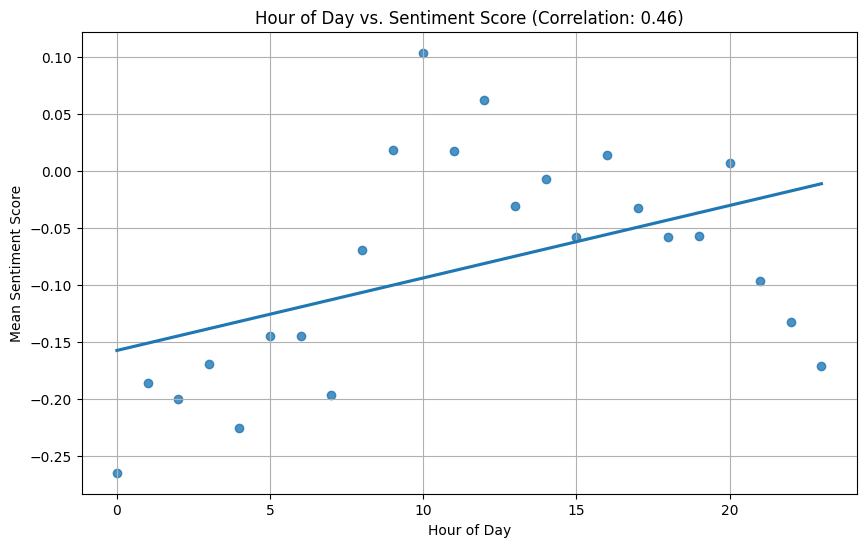

0.45680501222628705

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Re-calculate the correlation coefficient
correlation = mean_sentiment_by_hour['sentiment_score'].corr(mean_sentiment_by_hour['hour_of_day'])

# Visualize the relationship between hour of day and sentiment score
plt.figure(figsize=(10, 6))
sns.regplot(x='hour_of_day', y='sentiment_score', data=mean_sentiment_by_hour, ci=None)
plt.title(f'Hour of Day vs. Sentiment Score (Correlation: {correlation:.2f})')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Sentiment Score')
plt.grid(True)
plt.show()

correlation

## Splitting training and test text
Above, we used a number of external measures of text, meaning that the measures were developed without any influence from this dataset. For annotations, it was Mechanical Turk workers measuring the text. For length, that is a mathematical count of characters. For sentiment, it was from a BERT model not trained on the Internet Arguments Corpus.

This is not always the case. Consider if we want to make a measure of the text based on topic modeling. We build an LDA topic model of these comments, then we select an appealingly relevant topic and measure what number of words from Topic 1 each comment uses. Can we put that measure in the regression? We could, but it would lead to a biased estimate of the true effect size because our measure is no longer external or exogenous. The measure and model are double-dipping from the same textual information. This is important to keep in mind for your final projects, and for a more thorough explanation and justification, you can read more about this in [Egami et al. 2018](https://arxiv.org/pdf/1802.02163.pdf).

One approach to this in the Internet Arguments Corpus would be to build measures with the `pairs` that were not also `triples`. Sometimes we have excess data like this that is similar enough to our regression data, which we can use without reducing our regression sample size. For example, you could abductively generate a keyword-count measure like "argumentativeness" or "thoughtfulness" from non-triple pairs that isn't already in the annotations, and then count the keywords in the triples. You could develop an LDA model or word embedding measurement on some of the data, and the use it to establish an inferential relationship on the rest of the data. This would avoid contamination.

## <font color="red">*Exercise 3*</font>

<font color="red">Propose a measure you could generate to fill in or improve upon the simple causal model you proposed above and how you would split the data (e.g., a % of your main data, a separate-but-informative dataset). You do not have to produce the measure.
    
<font color="red">***Stretch*** (not required): Produce the measure and integrate it into your statistical analysis. This could be a great approach for your final project!

I want to measure engagement and influence index. Which could be a composite metric that accounts for:

**User Activity**: Frequency and recency of posts.

**User Influence**: Number of replies and likes a user's post receives, indicating the user's influence in the forum.

**Content Richness**: The average length of a user's posts or use of multimedia, which may reflect the effort and quality of engagement.


And here are how I plan to meausre them:

**User Activity**: Calculate the mean time interval between successive posts for each user.

**User Influence**: Sum the total number of replies and likes for each user's posts.

**Content Richness**: Calculate the average length of posts for each user.


## Data Split Strategy:
**Temporal Split**: Separate the dataset into two periods. Use the earlier period (e.g., first 70% of time) to develop, then test its predictive power on the remaining 30% of the data.

**Random Split with Stratification**: Randomly split the dataset while ensuring a proportional representation of high and low engagement users in both the training and testing sets.

**Cross-Validatio**n: Use k-fold cross-validation to assess the robustness of the engagement and influence index, ensuring that every data point is used for both training and validation across different folds.

# Text as mediator

What if text is instead the _mediator_, meaning it is effected by the teatment and effects the outcome? (A moderator influences the relationship a treatment has on the outcome. This figure from [Bhandari](https://www.scribbr.com/methodology/mediator-vs-moderator/) concisely shows the difference

<img src="https://cdn.scribbr.com/wp-content/uploads/2021/03/mediator-and-moderator-variables.png" alt="https://cdn.scribbr.com/wp-content/uploads/2021/03/mediator-and-moderator-variables.png" style="width:500px">
The moderating impact of a variable can simply be captured by in/excluding the variable alongside the purported cause of interest.)

Let's briefly return to the Internet Arguments Corpus triples and model the effect of the first comment ("quote") on the third comment ("response2") mediated by the second comment ("response1"). Unfortunately we don't have Turker annotations for the first comment, but we can propose a simple mediation model for the propogation of comment length from first to second to third. In other words: _Is there a causal chain of comment length through a conversation?_

A two-step mediation model consists of two linear models, one for each step. Let's create length_q and sentiment_q variables for our model.

In [ ]:
triples['length_q'] = triples['quote'].apply(lambda x: len(x))

In [ ]:
%%time

triples['sentiment_q'] = triples['quote'].apply(lambda x: sentiment(x[:512])[0]['score'])

CPU times: user 2min 24s, sys: 185 ms, total: 2min 24s
Wall time: 2min 24s


To run this analysis, statsmodel (sm) has a convenient `Mediation` module that takes in two linear models and outputs a mediation model.

In [ ]:
# Mediation analysis
y = triples['length_r1']
X_cols = ['sentiment_q','length_q']
X = sm.add_constant(triples[X_cols])
mediator_model = sm.OLS(y,X)

# For the second step of the mediation model, we can add in other predictors.
y = triples['length_r2']
X_cols = ['sentiment_q','length_q','fact-feeling_r1','nicenasty_r1','sarcasm_r1','length_r1','sentiment_r1']
X = sm.add_constant(triples[X_cols])
outcome_model = sm.OLS(y,X)

med = Mediation(outcome_model=outcome_model, mediator_model=mediator_model,
                exposure='length_q', mediator='length_r1').fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.051635,-7.504602,6.879604,0.984
ACME (treated),0.051635,-7.504602,6.879604,0.984
ADE (control),0.073303,0.020524,0.126238,0.006
ADE (treated),0.073303,0.020524,0.126238,0.006
Total effect,0.124937,-7.410314,6.933450,0.964
Prop. mediated (control),0.993800,0.676423,1.297186,0.020
Prop. mediated (treated),0.993800,0.676423,1.297186,0.020
ACME (average),0.051635,-7.504602,6.879604,0.984
ADE (average),0.073303,0.020524,0.126238,0.006
Prop. mediated (average),0.993800,0.676423,1.297186,0.020


It looks like the Average Causal Mediated Effect (ACME) is not significantly different from zero, but the Average Direct Effect (ADE) is. This suggests that the true causal relationship here is more likely:

_length_q -> length_r2_

than

_length_q -> length_r1 -> length_r2_

What do you think explains that relationship?

Once you are done with the Internet Arguments Corpus `iac_v1.1.zip` file, you may want to delete it if you are going to `git push` this directory because of [GitHub's limits on file sizes above 100 MB](https://docs.github.com/en/repositories/working-with-files/managing-large-files/about-large-files-on-github).

In [ ]:
os.remove('iac_v1.1.zip')

## <font color="red">*Exercise 4*</font>

<font color="red">Propose a mediation model related to the simple causal model you proposed above (ideally on the dataset you're using for your final project). If you have measures for each variable in the model, run the analysis: You can just copy the "Mediation analysis" cell above and replace with your variables. If you do not have measures, do not run the analysis, but be clear as to the effect(s) you would like to estimate and the research design you would use to test them.

**Independent Variable (X)**: Sentiment Score of the Post (calculated as Positive - Negative from RoBERTa's output)

**Dependent Variable (Y)**: Engagement Level (which could be a composite measure of replies, likes, and post frequency if we had this data)

**Mediator Variable (M)**: Time of Posting (hour of the day when the post was made)

**Here is how I design the measurement:**

**Measure Each Variable**:

**X (Sentiment Score)**: Already calculated from RoBERTa's output as data['sentiment_score'].
**Y (Engagement Level)**: This would need to be calculated if the data are available, taking into account replies, likes, and frequency of posts by each user.
**M (Time of Posting)**: Extracted from the data['hour_of_day'].

**Run Regression Analyses**:

**Step 1**: Regress Y on X to establish that the sentiment score predicts engagement level.

**Step 2**: Regress M on X to show that the sentiment score predicts the time of posting.

**Step 3**: Regress Y on X and M together to see if M accounts for the X-Y relationship.

**Test for Mediation**:

Use the coefficients from the regression analyses to see if the inclusion of M reduces the effect of X on Y or if M completely accounts for the relationship.


# Text as confounder
The causal effect we're interested in estimating might not be our causal relationship of interest. Instead, it could be another variable that affects both our treatment and outcome, known as a _confounder_. Recall the [Keith et al. 2020](https://aclanthology.org/2020.acl-main.474.pdf) figure showing the role of a confounder.

<img src="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" alt="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-6/img/causal_diagram.png" style="width:500px">

Why do we need to control for confounders? If we didn't, we might correctly find that the treatment and outcome are correlated, but rather than one causing the other, they could both be caused by a third variable. For example, if we are studying the effect of the journal a paper is published in on the citations of the paper, we may be worried that the text of the article affects both whether it is published by the journal and whether people cite it.

The factors we controlled for in the Internet Arguments Corpus could be seen as confounders, but there are also specific methods to control for text confounders. As an example, we will walk through the method proposed by [Pryzant et al. (2018)](https://nlp.stanford.edu/pubs/pryzant2018lexicon.pdf).

Say that we want to know the effect of product descriptions on product popularity. If I'm a shoe seller, how should I describe my shoes to maximize sales? Suppose I have data on sales of other shoes and want to learn from it:

| Description   | Brand   | Sales |
|---------------|---------|-------|
| buy shoes !     | addidas | 15    |
| fresh nike shoes !  | nike    | 35    |
| nice nike shoes ! | nike    | 17    |

It looks like "nike" is associated with higher sales! But that doesn't help me very much because I can't just advertise my shoes as Nikes. That would be incorrect and illegal (false advertising). What if we could build a lexicon of words like "nike" associated with certain brands and control for that in my analysis? We could then identify brand-agnostic words like "fresh" that have the causal effect of interest. This is the approach by Pryzant et al.


There are several packages that you can use for this purpose.

The first is "causal_attribution": https://github.com/rpryzant/deconfounded-lexicon-induction

The second is "causalnlp": https://github.com/amaiya/causalnlp

Unfortunately, both packages have been created several years ago and are not compatible with default setting of google colab. But you can always downgrade the version of python and jupyter notebook first to install them, or change the source codes if you need. The codes can be found in the urls provided above.

More papers for the same topic:
https://github.com/causaltext/causal-text-papers

# "Causally sufficient" embedding and topic models
Our final example of causal inference with text is from Victor Veitch (now a statistics and CS professor at UChicago), Sridhhar, and Blei. You may recall Blei as the lead developer of LDA, HDP, and Dynamic topic models, among other amazing contributions to content analysis.

Their 2020 paper, ["Adapting Text Embeddings for Causal Inference"](https://arxiv.org/abs/1905.12741), proposes reducing the dimensions of contextual text embeddings (from BERT) in a manner that preserves causally relevant text signals. For example: "Does adding a theorem to a paper affect its chance of acceptance?" We can apply supervised dimensionality reduction to make the embedding easier to analyze (i.e., lower dimension) but preserve information about whether theorems are present. Similar to Pryzant et al., Veitch et al. have a great [GitHub respository](https://github.com/blei-lab/causal-text-embeddings) with the data and code for their paper, and their dataset of computer science papers, PeerRead, has its own great [repo](https://github.com/allenai/PeerRead).

Their code is somewhat too hefty and farflung for this assignment, but for your future research, keep in mind that you can adjust your textual objects (e.g., keyword counts, topic models, word embeddings) for causal models. Bringing together unsupervised machine learning with causal inference is an exciting and rapidly developing field!

## <font color="red">*Exercise 5*</font>

<font color="red">Pick one other paper on causal inference with text from the ["Papers about Causal Inference and Language
" GitHub repository](https://github.com/causaltext/causal-text-papers). Write at least three sentences summarizing the paper and its logic of design in your own words.
    
<font color="red">***Stretch*** (not required): Skim a few more papers. The causal world is your textual oyster!

The artile "A Social Media Study on the Effects of Psychiatric Medication Use," utilizes a dataset of 300 million Twitter posts from 30,000 individuals to examine the psychopathological effects associated with the self-reported use of psychiatric medication. By developing machine learning models, the study assesses changes in mood, cognition, depression, anxiety, psychosis, and suicidal ideation following medication use. The research adopts a stratified propensity score-based causal analysis to understand how specific drugs are linked to changes in an individual's psychopathology, aiming to bridge the gap in precision psychiatry by leveraging real-world, patient-centered insights from social media activities.

By analyzing Twitter data, it reveals characteristic changes in psychopathology associated with drug use, providing valuable insights into pre-treatment cues that predict treatment outcomes.